# **Embeddings in Keras**
* ## Instead of using one hot encoding for each unique word, more meaningful word embeddings can be used
* ## E.g., Word2Vec, GloVe (Global Vectors for Word Representation)
> * ### You will study them in details in dedicated classes
* ## Here we focus on how to learn a word embedding directly in Keras usinf the ```Embedding``` layer
> * ### It learns a linear transformation matrix ***E*** that maps the one hot vectors representing the $n$ distinct words onto lower-dimensional feature vectors, the embedding space of dimension $d$
> * ### Then, **to save computation, it stores the lookup table of size $n\times d$ containing the embedding for each unique word** (index from $0$ to $n-1$)
>> ### unfortunately, this means the parameters are not the weight in $E$, but directly the embeding values!
>> * #### so $n\times d$ parameters!
> * ### **Example**. With $10$ words and embedding dimension $2$, the lookup table can similar to

In [95]:
# +------------+------------+
# |   index    |  Embedding |
# +------------+------------+
# |     0      | [1.2, 3.1] |
# |     1      | [0.1, 4.2] |
# |     2      | [1.0, 3.1] |
# |     3      | [0.3, 2.1] |
# |     4      | [2.2, 1.4] |
# |     5      | [0.7, 1.7] |
# |     6      | [4.1, 2.0] |
# |     7      | [0.1, 1.4] |
# |     8      | [0.2, 1.3] |
# |     9      | [4.3, 2.7] |
# +------------+------------+

>  ### Thus, the word of index $2$, which would correspond to the one-hot vector $v_2 = (0,0,1,0,0,0,0,0,0,0,0)$, is embedded onto the vector $v_2\cdot\boldsymbol{E}=(1.0,3.1)$.
> ### **The transofmation matrix $\boldsymbol{E}$, however, is only symbolic, it is not computed nor stored**
> ### **Since we learn directly the results of the dot product input one hot vector dot product $E$,  we do not neither need to perform the dot product**
> * ### The main difference with standard word embedding strategies is that embedding trained as any other parameter in the model via backpropagation
> * ### Accordingly, it is not able to capture general word semantic similarities, but only some word features specific for the current task  

# **Keras Embedding Layer** ([docs](https://keras.io/api/layers/core_layers/embedding/))

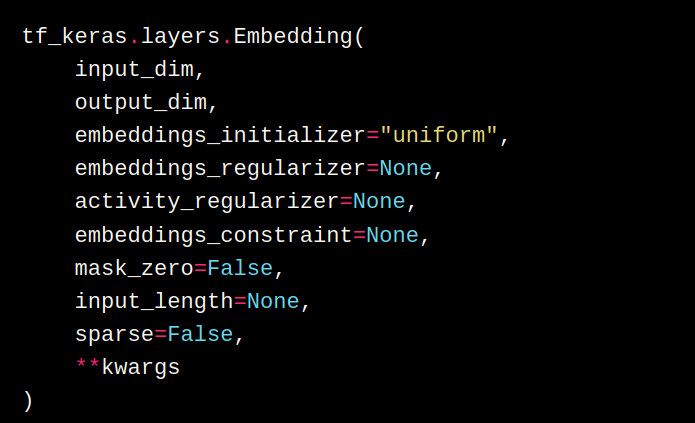


## Main Arguments
* ### **input_dim**: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
* ### **output_dim**: Integer. Dimension of the dense embedding.
* ### **input_length**: Integer. Length of sequence of words received as input (temporal steps of the subsequent LSTM)

# Accordingly, **we do not need to transforms words into their one-hot vectors**, we can supply just their intergers and use the *sparse_categorical_crossentropy* loss
# Let's repeat the experiment with Gutemberg ebook

In [96]:
import numpy as np
from keras.models import Sequential, load_model
from keras.layers import LSTM, Embedding
from keras.layers import Dense
import tensorflow as tf


In [97]:
!curl -O https://www.gutenberg.org/files/1661/1661-0.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  593k  100  593k    0     0   319k      0  0:00:01  0:00:01 --:--:--  319k


In [98]:
%ls

1661-0.txt  drive/  sample_data/


In [99]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
path = '1661-0.txt'
text = open(path).read().lower()
print('corpus length, number of characters:', len(text))
print(f"text[:100]:{text[:100]}")
max_size=100000
# cutting text due to memory size limitations
text = text[:max_size]
print('selected length, number of characters:', len(text))

corpus length, number of characters: 581425
text[:100]:﻿the project gutenberg ebook of the adventures of sherlock holmes,
by arthur conan doyle

this ebook
selected length, number of characters: 100000


In [101]:
import string
def get_words(text):
  text = text.replace('--', ' ')
  # split into tokens by white space
  words = text.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  words = [w.translate(table) for w in words]
  # remove remaining tokens that are not alphabetic
  words = [word for word in words if word.isalpha()]
  # make lower case
  words = [word.lower() for word in words]
  return words

words = get_words(text)
tot_uniq_words =  len(set(words))
print(words[:20])
print(f"Total words: {len(words)}")
print(f"Unique words: {tot_uniq_words}")

['project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of']
Total words: 17106
Unique words: 3019


# Creating a dictionary of unique strings, associated with a unique integer, starting from ```0``` to ```len(unique_words) - 1```




In [102]:
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))
print(f"unique_word_index:{unique_word_index}")
print(f"Unique words[:10]:{unique_words[:10]}")

unique_word_index:{np.str_('a'): 0, np.str_('abandoned'): 1, np.str_('abbots'): 2, np.str_('abhorrent'): 3, np.str_('able'): 4, np.str_('about'): 5, np.str_('above'): 6, np.str_('abruptly'): 7, np.str_('absence'): 8, np.str_('absolute'): 9, np.str_('absolutely'): 10, np.str_('absorb'): 11, np.str_('abutted'): 12, np.str_('accent'): 13, np.str_('accomplice'): 14, np.str_('accomplished'): 15, np.str_('account'): 16, np.str_('accountant'): 17, np.str_('accustomed'): 18, np.str_('acid'): 19, np.str_('acknowledge'): 20, np.str_('acknowledges'): 21, np.str_('acquaintance'): 22, np.str_('across'): 23, np.str_('action'): 24, np.str_('actions'): 25, np.str_('active'): 26, np.str_('activity'): 27, np.str_('actor'): 28, np.str_('actress'): 29, np.str_('acute'): 30, np.str_('added'): 31, np.str_('addition'): 32, np.str_('address'): 33, np.str_('addressing'): 34, np.str_('adjusted'): 35, np.str_('adler'): 36, np.str_('admirable'): 37, np.str_('admirably'): 38, np.str_('admiration'): 39, np.str_('ad

# **Then we need to create sequences of training data**
 * ## we take ```NPREV_WORDS``` words and predict the next one
 * ## **We now use the integer encoding for strings, as required by the embedding layer**


In [103]:
NPREV_WORDS = 5
prev_words = []
next_word = []
for i in range(len(words) - NPREV_WORDS):
    seq = [unique_word_index.get(tmp) for tmp in words[i:i + NPREV_WORDS]]
    if len(seq)!= NPREV_WORDS:
      print(len(seq))
    else:
      prev_words.append(seq)
      # the label
      next_word.append(unique_word_index.get(words[i + NPREV_WORDS]))
print(prev_words[0:3])
print(next_word[0:3])

[[2043, 1188, 811, 1812, 2666], [1188, 811, 1812, 2666, 45], [811, 1812, 2666, 45, 1812]]
[45, 1812, 2360]


In [104]:
total_words = len(prev_words)
X = np.array(prev_words)
Y = np.array(next_word)
print(f"X[0][0]:{X[0][0]}")
print(f"Y[0][0]:{Y[0]}")
print(f"print(X.shape):{X.shape}")

X[0][0]:2043
Y[0][0]:45
print(X.shape):(17101, 5)


# **Creating the model**
* ## To the embedding layer we need to pass the *number of distinct words* $n$ as first argument, the *embedding size* $d$, and the *input sequence length* $N$ (number of temporal steps)
* ## The *embedding* layer has an output dimension $N\times d$, the embedding of all the input words in this temporal window  

In [105]:
#   remind, the NPREV_WORDS we used now represent the
#   numeber of time steps considered in the LSTM recurrence
#   so automatically by the LSTM implementation,
#   the NPREV_WORDS words are fed to the cell one by one
emb_size = 50 # size of the embedding space
model = Sequential()
nunits = 16 # number of hidden units in LSTMcell
model.add(Embedding(tot_uniq_words, emb_size, input_length=NPREV_WORDS))
model.add(LSTM(units=nunits))
# dense layer stacked atop to classify with softmax
model.add(Dense(tot_uniq_words, activation='softmax'))
model.build(input_shape=(None, NPREV_WORDS))
print(model.summary())
model_file = "NWP_EMB"+str(emb_size)+"model"+str(nunits)+".weights.h5"
import os
if os.path.isfile(model_file):
  model.load_weights(model_file)
  print("file exists, loading")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-4),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 5, 50)          │       150,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_21 (LSTM)                  │ (None, 16)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 3019)           │        51,323 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,561 (806.88 KB)

 Trainable params: 206,561 (806.88 KB)

 Non-trainable params: 0 (0.00 B)

None


In [106]:
if not os.path.isfile(model_file):
  # training the model

  batch_size = 16
  epochs = 650
  #epochs = 150
  history = model.fit(x=X,y=Y,
            epochs=epochs,
            batch_size = batch_size,
            shuffle=True)
  # saving the trained weights
  model.save_weights(model_file)

Epoch 1/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.0508 - loss: 7.1296
Epoch 2/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.0552 - loss: 6.1731
Epoch 3/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.0583 - loss: 6.0362
Epoch 4/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.0584 - loss: 5.9968
Epoch 5/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.0533 - loss: 5.9365
Epoch 6/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.0568 - loss: 5.8986
Epoch 7/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.0586 - loss: 5.8700
Epoch 8/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.0577 - loss: 5.8052
Epoch 9/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.0581 - loss: 5.7775
Epoch 10/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 19s 14ms/step - accuracy: 0.0625 - loss: 5.7439
Epoch 11/650
1069/1069 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.0646 - loss: 5.7046
Epoch 

ValueError: The filename must end in `.weights.h5`. Received: filepath=NWP_EMB50model16.h5

In [107]:
model_file = "NWP_EMB50model16.weights.h5"
model.save_weights(model_file)

# With embedding we did not reach a pleateau, more training epochs likely to be necessary
* ## The increased number of parameters need more training epochs, and in general specific refinements

# **Bidirectional RNNs**
* ## In Keras we can implement a bidirection RNN using a ```Bidirectional``` layer ([docs](https://keras.io/api/layers/recurrent_layers/bidirectional/))

keras.layers.Bidirectional(

>layer,

>merge_mode="concat",

>weights=None,

>backward_layer=None, **kwargs
)

# Main arguments
> * ### **layer**: keras.layers.RNN instance, such as keras.layers.LSTM or keras.layers.GRU. Should be a sequence-processing layer
> * ### **merge_mode**: Mode by which outputs of the forward and backward RNNs will be combined. One of {"sum", "mul", "concat", "ave", None}. Defaults to "concat".
> * ### **backward_layer**: Optional keras.layers.RNN, or keras.layers.Layer instance to be used to handle backwards input processing.
>> * #### If backward_layer is not provided, the layer instance passed as the layer argument will be used to generate the backward layer automatically.
>> * #### Can be different than ```layer``` (see docs)

# We first prepare re-process the data so as to use one-hot encoding instead of embedding layers (like in the previous lecture)

In [108]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Embedding,Dense, Bidirectional, Input
import tensorflow as tf

path = '1661-0.txt'
text = open(path).read().lower()
max_size=100000
# cutting text due to memory size limitations
text = text[:max_size]
print('selected length, number of characters:', len(text))

import string
def get_words(text):
  text = text.replace('--', ' ')
  # split into tokens by white space
  words = text.split()
  # remove punctuation from each token
  table = str.maketrans('', '', string.punctuation)
  words = [w.translate(table) for w in words]
  # remove remaining tokens that are not alphabetic
  words = [word for word in words if word.isalpha()]
  # make lower case
  words = [word.lower() for word in words]
  return words

words = get_words(text)
tot_uniq_words =  len(set(words))
print(words[:200])
print(f"Total words: {len(words)}")
print(f"Unique words: {tot_uniq_words}")

NPREV_WORDS = 5
prev_words = []
next_word = []
for i in range(len(words) - NPREV_WORDS):
    seq = words[i:i + NPREV_WORDS]
    if len(seq)!= NPREV_WORDS:
      print(len(seq))
    else:
      prev_words.append(seq)
      # the label
      next_word.append(words[i + NPREV_WORDS])
print(prev_words[0:3])
print(next_word[0:3])

X = np.zeros((len(prev_words), NPREV_WORDS, tot_uniq_words), dtype=bool)
Y = np.zeros((len(next_word), tot_uniq_words), dtype=bool)
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1 # position for the one-hot
    Y[i, unique_word_index[next_word[i]]] = 1

print(f"X[0][0]:{X[0][0]}")
print(f"Y[0][0]:{Y[0]}")
print(f"print(X.shape):{X.shape}")

selected length, number of characters: 100000
['project', 'gutenberg', 'ebook', 'of', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'in', 'the', 'united', 'states', 'and', 'most', 'other', 'parts', 'of', 'the', 'world', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', 'you', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 'reuse', 'it', 'under', 'the', 'terms', 'of', 'the', 'project', 'gutenberg', 'license', 'included', 'with', 'this', 'ebook', 'or', 'online', 'at', 'wwwgutenbergorg', 'if', 'you', 'are', 'not', 'located', 'in', 'the', 'united', 'states', 'you', 'will', 'have', 'to', 'check', 'the', 'laws', 'of', 'the', 'country', 'where', 'you', 'are', 'located', 'before', 'using', 'this', 'ebook', 'title', 'the', 'adventures', 'of', 'sherlock', 'holmes', 'author', 'arthur', 'conan', 'doyle', 'release', 'date', 'november', 'ebook', 'most', 'recen

# **Creating the Bidirectional model**
* ## Use a similar number of parameters used for the one directional one
* ## Since it has two "parallel" RNN models, to keep the same number of parameters, we need to half the hidden state dimension

In [116]:
nhunits = 8
model = Sequential()
model.add(Input(shape=(NPREV_WORDS, tot_uniq_words)))
model.add(Bidirectional(LSTM(units=nhunits)))
# dense layer stacked atop to classify with softmax
model.add(Dense(tot_uniq_words, activation='softmax'))

print(model.summary())
model_file = "NWP_LSTM"+str(nhunits)+"_BIDIR.weights.h5"
import os
to_train=True
if os.path.isfile(model_file):
  to_train= False
  model.load_weights(model_file)
  print("file exists, loading")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5*10**-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 16)             │       193,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3019)           │        51,323 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,115 (957.48 KB)

 Trainable params: 245,115 (957.48 KB)

 Non-trainable params: 0 (0.00 B)

None
file exists, loading


In [117]:
if not os.path.isfile(model_file):
  # train the model
  batch_size = 16
  epochs = 650
  #epochs = 150
  history = model.fit(x=X,y=Y,
            epochs=epochs,
            batch_size = batch_size,
            shuffle=True)
  # saving the trained weights
  model.save_weights(model_file)



In [113]:
model_file = "bidirectional.weights.h5"
model.save_weights(model_file)

In [ ]:
model_file2 = "drive/MyDrive/lecture-13a/bidirectional.weights.h5"
model.save_weights(model_file2)

# **Using the model to reconstruct a text**
* ## Measure the performance as accuracy in predicting the next word

In [111]:
# transorm the input "text" in one samples formed by its words.
# "text" should contain NPREV_WORDS words
def prepare_input(text, NPREV_WORDS, tot_uniq_words, word_dict):
    x = np.zeros((1, NPREV_WORDS, tot_uniq_words))
    for t, word in enumerate(text.split()):
        word = word.lower()
        if word not in word_dict:
          print(f"word:{word} not in dictionary!")
          exit()
        # stop when number of time steps reached
        if t >= NPREV_WORDS:
          break
        else:
          x[0, t, word_dict[word]] = 1
    return x

# input text to be predicted, the dictionary of words on which the model has
# been trained
def predict_completion(model, text, NPREV_WORDS, tot_uniq_words, word_dict):
    original_text = text
    generated = text
    next_word = ''
    x = prepare_input(text, NPREV_WORDS, tot_uniq_words, word_dict)
    preds = model.predict(x, verbose=0)[0]
    #print(f"preds.shape:{preds.shape}")
    # taking next word as the one with maximum probability
    #  should be extracted
    next_index = np.argmax(preds)
    next_word = list(word_dict.keys())[list(word_dict.values()).index(next_index)]
    return next_word

# number of words to recontstuct
recon_len = 500
ini = 190 # postion in the input text Where a whole sentence starts.

test = words[ini:ini+NPREV_WORDS]
# concatenate string list into a text separated
test_text = " ".join(test)
print(f"initial text: {test_text}")
recon_text = []
# recontructing text with the predicted words in sequence, then compare with the true text
for i in range(recon_len):
  recon_text.append(predict_completion(model, test_text, NPREV_WORDS, tot_uniq_words, unique_word_index))
  test[:NPREV_WORDS-1] = test[1:NPREV_WORDS]
  test[NPREV_WORDS-1] = words[ini+i+NPREV_WORDS]
  test_text = " ".join(test)

real_text = words[ini+NPREV_WORDS:ini+NPREV_WORDS+recon_len]
accuracy = np.sum([1 if recon_text[i]== real_text[i] else 0 for i in range(recon_len)])/recon_len
## Visual check
print(f"real text:{words[ini+NPREV_WORDS:ini+15+NPREV_WORDS]}")
print(f"recon_text:{recon_text[:15]}")
print(f"Total accuracy:{accuracy}")

initial text: of the speckled band ix
real text:['the', 'adventure', 'of', 'the', 'thumb', 'x', 'the', 'adventure', 'of', 'the', 'noble', 'bachelor', 'xi', 'the', 'adventure']
recon_text:[np.str_('the'), np.str_('adventure'), np.str_('of'), np.str_('the'), np.str_('speckled'), np.str_('x'), np.str_('the'), np.str_('adventure'), np.str_('of'), np.str_('the'), np.str_('noble'), np.str_('bachelor'), np.str_('xi'), np.str_('the'), np.str_('adventure')]
Total accuracy:0.956
